<a href="https://colab.research.google.com/github/berthine/SIAM-Summer-School/blob/main/SIAM2021_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practical: DCGANs (MNIST)
(26/July/2021)

### 2021 Gene Golub SIAM Summer School 
https://sites.google.com/aims.ac.za/g2s3/home 

Instructor

<font color="green">***Dr. Emmanuel Dufourq*** 

www.emmanueldufourq.com

edufourq (['@']) gmail.com

***African Institute for Mathematical Sciences***

***Stellenbosch University***

***2021***

Material adapted from: https://www.tensorflow.org/tutorials/generative/dcgan

Code licensed under https://www.apache.org/licenses/LICENSE-2.0

In this practical you will learn how to implement the autoencoder using CNNs.




## <font color="green"> Learning outcomes:

* Generate images of handwritten digits using a Deep Convolutional Generative Adversarial Network (DCGAN).

## <font color="green">Data information:

* Features: (28x28) images

* Output: (28x28) images

## <font color="green">Tasks for participants (boolean)?

* No, follow along and make your own modifications and make sure you understand


## Import TensorFlow and other libraries

In [ ]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_a_kb2ya
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-_a_kb2ya
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.047a807024a49d648ff635434d49e3f03a8cfc57a_-cp37-none-any.whl size=154244 sha256=053e7d539519cf678ad67863c4c9902d432fce898949b51f8eb5797ae44657d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-llj1w0ww/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


### Load the dataset

Note we don't need the texting images and labels since we are not classifying or evaluating on test data.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### Reshape the data so that it has a 1 to indicate the depth of each image

In [ ]:
train_images = train_images[..., tf.newaxis].astype('float32')

### Normalise between -1 and 1

[Radford et al. https://arxiv.org/pdf/1511.06434.pdf]

"The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution."

In [ ]:
train_images = (train_images - 127.5) / 127.5

In [ ]:
train_images.shape

(60000, 28, 28, 1)

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

### Some explanations are needed here!







```.from_tensor_slices()``` : The given tensors are sliced along their first dimension. This operation preserves the structure of the input tensors, removing the first dimension of each tensor and using it as the dataset dimension

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(np.asarray([[1, 2, 3], [4, 5, 6]]))
list(dataset.as_numpy_iterator())

[array([1, 2, 3]), array([4, 5, 6])]

```.batch()``` : Combines consecutive elements of this dataset into batches.

In [ ]:
dataset = tf.data.Dataset.range(8)
dataset = dataset.batch(3)
list(dataset.as_numpy_iterator())

[array([0, 1, 2]), array([3, 4, 5]), array([6, 7])]

```.shuffle()``` : For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer.

In [ ]:
dataset = tf.data.Dataset.range(18)
dataset = dataset.shuffle(2)
list(dataset.as_numpy_iterator())

[0, 2, 3, 1, 4, 6, 7, 5, 8, 10, 9, 11, 12, 13, 15, 16, 14, 17]

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train_dataset.element_spec

TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). We saw this layer in the previous notebook when we created decoders.



Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. 

Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh. This is set because of the definition in the DCGAN paper, "we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to workwell, especially for higher resolution modeling. This is in contrast to the original GAN paper, whichused the maxout activation (Goodfellow et al., 2013)." https://arxiv.org/abs/1511.06434

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    # Here is the first fully connected layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # If we want to use conv2dtranspose we need to first reshape the previous layer
    model.add(layers.Reshape((7, 7, 256)))

    # here, ```assert``` just makes sure the shape matches the paper's definition
    # this doesn't affect the architecture in any way and can be removed for simplicity
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    # Notice how the width and height of the resulting feature map after this layer does not change
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))

    # here, ```assert``` just makes sure the shape matches the paper's definition
    # this doesn't affect the architecture in any way and can be removed for simplicity
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Notice how the width and height of the resulting feature map after this layer DOES change
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))

    # here, ```assert``` just makes sure the shape matches the paper's definition
    # this doesn't affect the architecture in any way and can be removed for simplicity
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    # here, ```assert``` just makes sure the shape matches the paper's definition
    # this doesn't affect the architecture in any way and can be removed for simplicity
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

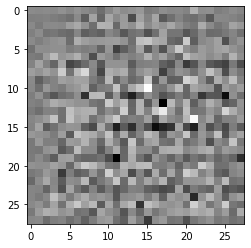

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier. The discriminator is basically like a normal CNN image classifier. We just have to be careful with the input and make sure it matches the output of the generator.

In [ ]:
def make_discriminator_model():

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images. How? This will become more clear when we discuss the discriminator loss below.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00154413]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
# This method returns a helper function to compute cross entropy loss

# This is the model's prediction, i.e, a single floating-point 
# value which either represents a logit, (i.e, value in [-inf, inf] when from_logits=True) 
# or a probability (i.e, value in [0., 1.] when from_logits=False).
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. 

It compares the **discriminator's predictions on real images to an array of 1s**, and the **discriminator's predictions on fake (generated) images to an array of 0s**. 

When we train the GAN, we (humans) know in advance which images are real (they come from our dataset) and which are fake (they come from the generator). Thus it makes sense that the real loss is a bunch of 1's compared to the real output, and that a bunch of 0's is compared to the fake (generated) output.

In [ ]:
def discriminator_loss(real_output, fake_output):
    # We know that these images are real so we compare the output to an array of 1's
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # We know that these are fake so we compare to an array of 0's
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # The total loss is both losses combined.
    total_loss = real_loss + fake_loss
    
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). E.g

If the fake_output (i.e output on the fake image) is [1, 1, 1, 1] on 4 images then the generator is doing well because the fake_output should be [0, 0, 0 ,0] if the discriminator can recognise that each image was fake. Remember the discriminator will output 0 (fake) 1(real).


Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

We have seen model checkpoitns before in previous pracs.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [ ]:
EPOCHS = 15
noise_dim = 100

num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Record operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      # Generate images
      generated_images = generator(noise, training=True)

      # Get the output for the real data
      real_output = discriminator(images, training=True)

      # Get the output for the "fake" generated data
      fake_output = discriminator(generated_images, training=True)

      # Compute the generator loss
      gen_loss = generator_loss(fake_output)

      # Compute the discriminator loss
      disc_loss = discriminator_loss(real_output, fake_output)

    # Use GradientTape to calculate the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients to variables. https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#apply_gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
# Define a training loop
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

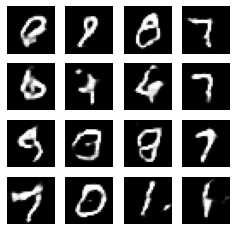

In [ ]:
train(train_dataset, 60)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

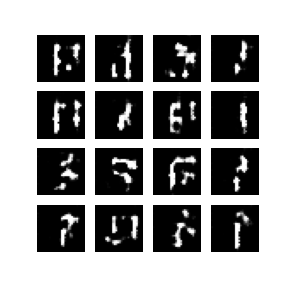

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


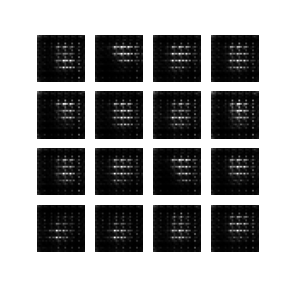

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)